## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 2e-5
EPOCHS = 300
BATCH_SIZE = 3
CROP_SIZE = 1024
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

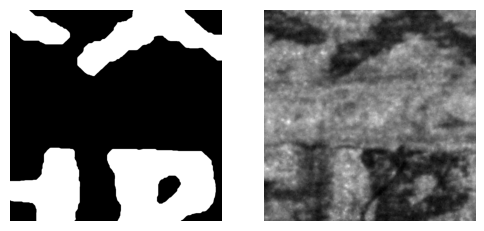

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4088

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
#                     if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
#                         self.xys.append((fragment, x, y, W, H))
        
#         self.train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
                
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
                
#                 # A.RandomBrightnessContrast(p=0.75),
#                 # A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
#                 #                 mask_fill_value=0, p=0.5),
#                 # A.ShiftScaleRotate(p=0.75),
                
#                 A.Rotate(limit=90, p=0.9), 
                
#                 # A.OneOf([
#                 #         A.GaussNoise(var_limit=[1, 5]),
#                 #         A.GaussianBlur(),
#                 #         A.MotionBlur(),
#                 #         ], p=0.4),
#                 # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
#                 #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
                
                
#                 ToTensorV2(transpose_mask=True),
#             ]
        
#         # Create the augmentation pipeline
#         self.augmentations = A.Compose(self.train_aug_list)
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-512 if x1 != 0 else 0, 512)
#         y_offset = random.randint(-512 if y1 != 0 else 0, 512)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         # if random.random() > 0.5:
#         #     frag_crop = np.flip(frag_crop, axis=1).copy()
#         #     mask_crop = np.flip(mask_crop, axis=1).copy()

#         # Perform train augmentations

#         # frag_crop = frag_crop/65535.0
#         frag_crop = frag_crop/255.0
        
        
        

#         # Apply the augmentations
#         augmented = self.augmentations(image=frag_crop, mask=mask_crop)

#         # Separate the image and mask
#         frag_crop, mask_crop = augmented["image"], augmented["mask"]

#         # normalize
        
#         # frag_crop = (frag_crop - 0.45)/0.225
        
#         frag_crop = frag_crop.unsqueeze(0)
#         mask_crop = mask_crop.float().unsqueeze(0)
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        self.train_aug_list = [
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                
                A.Rotate(limit=90, p=0.9), 
                
                A.Normalize(
                    mean= [0] * Z_DIMS,
                    std= [1] * Z_DIMS
                ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        
        # choose random fragment from self.fragments
        fragment = random.choice(self.fragments)
        
        # get y1, x1, x2, y2, that you want to crop
        y1 = random.randint(0, FRAGMENTS_ZARR[fragment].truth.shape[0] - CROP_SIZE)
        x1 = random.randint(0, FRAGMENTS_ZARR[fragment].truth.shape[1] - CROP_SIZE)
        y2 = y1 + CROP_SIZE
        x2 = x1 + CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
            
        # while True:
            
        #     if np.sum(frag_crop[:, :, 0]>0.01) / (CROP_SIZE * CROP_SIZE) > 0.1:
        #         break
            
        #     y1 = random.randint(0, FRAGMENTS_ZARR[fragment].truth.shape[0] - CROP_SIZE)
        #     x1 = random.randint(0, FRAGMENTS_ZARR[fragment].truth.shape[1] - CROP_SIZE)
        #     y2 = y1 + CROP_SIZE
        #     x2 = x1 + CROP_SIZE
            
            
        
        
        
        
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        # frag_crop = frag_crop/65535.0
        frag_crop = frag_crop/255.0
        
        
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return 128

In [15]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
        self.train_aug_list = [
                A.Normalize(
                    mean= [0] * Z_DIMS,
                    std= [1] * Z_DIMS
                ),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        # frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        # frag_crop = frag_crop/65535.0
        # # frag_crop = (frag_crop - 0.45)/0.225
        
        # mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        frag_crop = frag_crop/255.0
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [16]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [27]:
i = random.randint(0, len(dataset_train))
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.), tensor(1.0078))

In [18]:
i = random.randint(0, len(dataset_valid))
img = dataset_valid[i][0]
img.min(), img.max()

(tensor(0.), tensor(1.0078))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [63]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [64]:
model = SegModel()
# model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model.load_state_dict(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/exp-1-reproduce-training-with-augm-bce-dice-loss-size-768/ckpts/resnet18_3d_seg_best_0.5369.pt"))

model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

In [65]:
x = torch.randn(5, 1, 16, 256, 256)#.cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [66]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [67]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
#                                                 steps_per_epoch=20, epochs=EPOCHS//10,
#                                                 pct_start=0.5)

In [68]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()
FocalLoss = smp.losses.FocalLoss(mode='binary')

def criterion(y_pred, y_true):
    # return FocalLoss(y_pred, y_true)
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)   

In [69]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [70]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [ ]:
print("training started")

In [71]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    # cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    cur_lr = LR
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            loss.backward()
            optimizer.step()
            
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    # scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    
    out = {
        'train_loss': mloss_train / n_train,
        'val_loss': mloss_val / n_valid,
    }
    
    
    for threshold in np.arange(0.2, 1.00, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        out[f'fbeta_{threshold:.2f}'] = fbeta.item()
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    out["epoch"] = epoch
    df_out = pd.DataFrame(out, index=[0])
    
    if epoch == 1:
        !rm resnet18_3d_seg.csv
        df_out.to_csv("resnet18_3d_seg.csv", index=False)
    else:
        # first read the old csv file
        df_old = pd.read_csv("resnet18_3d_seg.csv")
        # append the new row to it
        df_new = pd.concat([df_old, df_out], ignore_index=True)
        # save the new csv file
        df_new.to_csv("resnet18_3d_seg.csv", index=False)
        
    # if epoch >= 10:
    #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 14.3GB  LR : 4.00E-06  Loss: 0.3932: 100%|██████████| 68/68 [00:38<00:00,  1.76it/s]
Val Loss: 0.4048: 100%|██████████| 21/21 [00:04<00:00,  4.37it/s]


Threshold : 0.20	FBeta : 0.394732
Threshold : 0.25	FBeta : 0.409599
Threshold : 0.30	FBeta : 0.422824
Threshold : 0.35	FBeta : 0.434801
Threshold : 0.40	FBeta : 0.444318
Threshold : 0.45	FBeta : 0.452984
Threshold : 0.50	FBeta : 0.462821
Threshold : 0.55	FBeta : 0.469625
Threshold : 0.60	FBeta : 0.475711
Threshold : 0.65	FBeta : 0.479582
Threshold : 0.70	FBeta : 0.482753
Threshold : 0.75	FBeta : 0.483710
Threshold : 0.80	FBeta : 0.482123



Epoch 2/50  Mem : 18.8GB  LR : 6.89E-06  Loss: 0.3701: 100%|██████████| 68/68 [00:40<00:00,  1.67it/s]
Val Loss: 0.4129: 100%|██████████| 21/21 [00:04<00:00,  4.42it/s]

Threshold : 0.20	FBeta : 0.425827
Threshold : 0.25	FBeta : 0.435252
Threshold : 0.30	FBeta : 0.442911
Threshold : 0.35	FBeta : 0.449170
Threshold : 0.40	FBeta : 0.454457
Threshold : 0.45	FBeta : 0.457734
Threshold : 0.50	FBeta : 0.460106
Threshold : 0.55	FBeta : 0.460009
Threshold : 0.60	FBeta : 0.460504
Threshold : 0.65	FBeta : 0.460103
Threshold : 0.70	FBeta : 0.455403
Threshold : 0.75	FBeta : 0.447339
Threshold : 0.80	FBeta : 0.435864




Epoch 3/50  Mem : 18.8GB  LR : 1.52E-05  Loss: 0.3698: 100%|██████████| 68/68 [00:34<00:00,  1.99it/s]
Val Loss: 0.4112: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]


Threshold : 0.20	FBeta : 0.455634
Threshold : 0.25	FBeta : 0.462802
Threshold : 0.30	FBeta : 0.467632
Threshold : 0.35	FBeta : 0.472457
Threshold : 0.40	FBeta : 0.477591
Threshold : 0.45	FBeta : 0.482067
Threshold : 0.50	FBeta : 0.485564
Threshold : 0.55	FBeta : 0.487558
Threshold : 0.60	FBeta : 0.489932
Threshold : 0.65	FBeta : 0.492653
Threshold : 0.70	FBeta : 0.494033
Threshold : 0.75	FBeta : 0.494264
Threshold : 0.80	FBeta : 0.494103



Epoch 4/50  Mem : 18.8GB  LR : 2.80E-05  Loss: 0.3663: 100%|██████████| 68/68 [00:33<00:00,  2.05it/s]
Val Loss: 0.4304: 100%|██████████| 21/21 [00:04<00:00,  4.52it/s]

Threshold : 0.20	FBeta : 0.394021
Threshold : 0.25	FBeta : 0.402557
Threshold : 0.30	FBeta : 0.408704
Threshold : 0.35	FBeta : 0.414617
Threshold : 0.40	FBeta : 0.419682
Threshold : 0.45	FBeta : 0.423711
Threshold : 0.50	FBeta : 0.427388
Threshold : 0.55	FBeta : 0.431315
Threshold : 0.60	FBeta : 0.434629
Threshold : 0.65	FBeta : 0.438321
Threshold : 0.70	FBeta : 0.441072
Threshold : 0.75	FBeta : 0.444660
Threshold : 0.80	FBeta : 0.449341




Epoch 5/50  Mem : 18.8GB  LR : 4.37E-05  Loss: 0.3922: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]
Val Loss: 0.4826: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]

Threshold : 0.20	FBeta : 0.352474
Threshold : 0.25	FBeta : 0.358332
Threshold : 0.30	FBeta : 0.363447
Threshold : 0.35	FBeta : 0.368073
Threshold : 0.40	FBeta : 0.372305
Threshold : 0.45	FBeta : 0.376554
Threshold : 0.50	FBeta : 0.382310
Threshold : 0.55	FBeta : 0.388127
Threshold : 0.60	FBeta : 0.393435
Threshold : 0.65	FBeta : 0.398119
Threshold : 0.70	FBeta : 0.401787
Threshold : 0.75	FBeta : 0.405004
Threshold : 0.80	FBeta : 0.408397




Epoch 6/50  Mem : 18.8GB  LR : 6.03E-05  Loss: 0.3919: 100%|██████████| 68/68 [00:32<00:00,  2.07it/s]
Val Loss: 0.4248: 100%|██████████| 21/21 [00:04<00:00,  4.48it/s]


Threshold : 0.20	FBeta : 0.492957
Threshold : 0.25	FBeta : 0.496932
Threshold : 0.30	FBeta : 0.498717
Threshold : 0.35	FBeta : 0.499718
Threshold : 0.40	FBeta : 0.500288
Threshold : 0.45	FBeta : 0.500748
Threshold : 0.50	FBeta : 0.501965
Threshold : 0.55	FBeta : 0.502617
Threshold : 0.60	FBeta : 0.500323
Threshold : 0.65	FBeta : 0.495778
Threshold : 0.70	FBeta : 0.489551
Threshold : 0.75	FBeta : 0.477893
Threshold : 0.80	FBeta : 0.459721



Epoch 7/50  Mem : 18.8GB  LR : 7.60E-05  Loss: 0.3856: 100%|██████████| 68/68 [00:33<00:00,  2.01it/s]
Val Loss: 0.5693: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]

Threshold : 0.20	FBeta : 0.190189
Threshold : 0.25	FBeta : 0.166612
Threshold : 0.30	FBeta : 0.149464
Threshold : 0.35	FBeta : 0.135492
Threshold : 0.40	FBeta : 0.122840
Threshold : 0.45	FBeta : 0.107806
Threshold : 0.50	FBeta : 0.059848
Threshold : 0.55	FBeta : 0.030948
Threshold : 0.60	FBeta : 0.020445
Threshold : 0.65	FBeta : 0.012945
Threshold : 0.70	FBeta : 0.006396
Threshold : 0.75	FBeta : 0.001602
Threshold : 0.80	FBeta : 0.000000




Epoch 8/50  Mem : 18.8GB  LR : 8.88E-05  Loss: 0.4172: 100%|██████████| 68/68 [00:33<00:00,  2.05it/s]
Val Loss: 0.6426: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]

Threshold : 0.20	FBeta : 0.274391
Threshold : 0.25	FBeta : 0.283037
Threshold : 0.30	FBeta : 0.290093
Threshold : 0.35	FBeta : 0.297132
Threshold : 0.40	FBeta : 0.304796
Threshold : 0.45	FBeta : 0.312649
Threshold : 0.50	FBeta : 0.320538
Threshold : 0.55	FBeta : 0.329374
Threshold : 0.60	FBeta : 0.339067
Threshold : 0.65	FBeta : 0.347441
Threshold : 0.70	FBeta : 0.354512
Threshold : 0.75	FBeta : 0.360832
Threshold : 0.80	FBeta : 0.367123




Epoch 9/50  Mem : 18.8GB  LR : 9.71E-05  Loss: 0.4040: 100%|██████████| 68/68 [00:32<00:00,  2.06it/s]
Val Loss: 0.4546: 100%|██████████| 21/21 [00:04<00:00,  4.56it/s]

Threshold : 0.20	FBeta : 0.453475
Threshold : 0.25	FBeta : 0.457426
Threshold : 0.30	FBeta : 0.460899
Threshold : 0.35	FBeta : 0.463569
Threshold : 0.40	FBeta : 0.465941
Threshold : 0.45	FBeta : 0.468440
Threshold : 0.50	FBeta : 0.472019
Threshold : 0.55	FBeta : 0.476809
Threshold : 0.60	FBeta : 0.479769
Threshold : 0.65	FBeta : 0.473241
Threshold : 0.70	FBeta : 0.453886
Threshold : 0.75	FBeta : 0.426530
Threshold : 0.80	FBeta : 0.390536




Epoch 10/50  Mem : 18.8GB  LR : 1.00E-04  Loss: 0.3785: 100%|██████████| 68/68 [00:34<00:00,  1.97it/s]
Val Loss: 0.5424: 100%|██████████| 21/21 [00:04<00:00,  4.51it/s]

Threshold : 0.20	FBeta : 0.325706
Threshold : 0.25	FBeta : 0.315770
Threshold : 0.30	FBeta : 0.305990
Threshold : 0.35	FBeta : 0.296578
Threshold : 0.40	FBeta : 0.285529
Threshold : 0.45	FBeta : 0.271925
Threshold : 0.50	FBeta : 0.257032
Threshold : 0.55	FBeta : 0.240058
Threshold : 0.60	FBeta : 0.221124
Threshold : 0.65	FBeta : 0.199660
Threshold : 0.70	FBeta : 0.176274
Threshold : 0.75	FBeta : 0.150822
Threshold : 0.80	FBeta : 0.118400




Epoch 11/50  Mem : 18.8GB  LR : 1.00E-04  Loss: 0.3757: 100%|██████████| 68/68 [00:33<00:00,  2.02it/s]
Val Loss: 0.5311: 100%|██████████| 21/21 [00:04<00:00,  4.50it/s]

Threshold : 0.20	FBeta : 0.343842
Threshold : 0.25	FBeta : 0.321611
Threshold : 0.30	FBeta : 0.303590
Threshold : 0.35	FBeta : 0.287626
Threshold : 0.40	FBeta : 0.271944
Threshold : 0.45	FBeta : 0.256315
Threshold : 0.50	FBeta : 0.238742
Threshold : 0.55	FBeta : 0.220394
Threshold : 0.60	FBeta : 0.198035
Threshold : 0.65	FBeta : 0.173294
Threshold : 0.70	FBeta : 0.142726
Threshold : 0.75	FBeta : 0.109096
Threshold : 0.80	FBeta : 0.077230




Epoch 12/50  Mem : 18.8GB  LR : 9.99E-05  Loss: 0.3672:  25%|██▌       | 17/68 [00:09<00:28,  1.78it/s]


KeyboardInterrupt: 

In [ ]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
